# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd
import sklearn as skl
import pandas as pd
from PIL import Image
import warnings
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassConfusionMatrix
from torcheval.metrics import MulticlassF1Score

from torcheval.metrics import BinaryAccuracy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_image_dir = fma_dir / 'spectrograms/fma_small'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'
fma_df_path = fma_dir / 'fma_df.csv'

In [4]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

In [5]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)

# Define function loading GTZAN df from file

In [6]:
def get_gtzan_dataframe(with_val):
    gtzan_df = pd.read_csv(gtzan_df_path)
    
    # turn relative paths into absolute paths
    gtzan_df['path'] = gtzan_df['path'].apply(lambda x: gtzan_image_dir / x)
    
    # SAMPLES: 800/98/100
    if (with_val):
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_val_df = gtzan_df[gtzan_df['set'] == 'validation']
        gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
        return gtzan_train_df, gtzan_val_df, gtzan_test_df
    else: # SAMPLES: 800/198
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_test_df = gtzan_df[(gtzan_df['set'] == 'test') | (gtzan_df['set'] == 'validation')]
        return gtzan_train_df, gtzan_test_df

# Load GTZAN df (with/without separate val set)

In [7]:
# with separate val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(with_val=True)

In [ ]:
# without separate val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(with_val=False)

# Define function loading FMA df from file

In [6]:
def get_fma_dataframe(get_fma_small, with_val):
    fma_df = pd.read_csv(fma_df_path)
    
    # turn relative paths into absolute paths
    fma_df['path'] = fma_df['path'].apply(lambda x: fma_medium_image_dir / x)
    
    # otherwise the dataset is FMA-medium
    if (get_fma_small):
        fma_df = fma_df[fma_df['size'] == 'small']
    
    # PERCENTAGES: 80/10/10
    if (with_val):
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_val_df = fma_df[fma_df['set'] == 'validation']
        fma_test_df = fma_df[fma_df['set'] == 'test']
        return fma_train_df, fma_val_df, fma_test_df
    else: # PERCENTAGES: 80/20
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_test_df = fma_df[(fma_df['set'] == 'test') | (fma_df['set'] == 'validation')]
        return fma_train_df, fma_test_df

# Load FMA df (with/without separate val set) (small/medium)

In [7]:
# fma-small with separate val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=True)

In [ ]:
# fma-small without separate val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=False)

In [7]:
# fma-medium with separate val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=True)

In [ ]:
# fma-medium without separate val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=False)

# Define input data loading functions - PyTorch

In [8]:
# 0, 1, 2, 3... labels used with nn.CrossEntropyLoss
def numerically_encode_class_label(class_name, available_classes):
  return available_classes.index(class_name)

# currently unused
def one_hot_encode_class_label(class_name, available_classes):
  label = available_classes.index(class_name)
  one_hot = np.zeros(len(available_classes))
  one_hot[label] = 1
  return one_hot

# decode png
def decode_img_data(img_path, channels=3):
  img = Image.open(img_path).convert('RGB' if channels == 3 else 'L') # convert to RGB if 3 channels, otherwise grayscale
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = np.array(img)
  img = torch.tensor(img).permute(2, 0, 1) if channels == 3 else torch.tensor(img).unsqueeze(0) # channels first
  return img.float() / 255.0 # normalize to [0, 1]

# return pair: decoded png and class name turned into numerical label
def process_sample(sample, available_classes, channels=3):
  img_path = sample[0]
  class_label = sample[1]
  
  img_data = decode_img_data(img_path, channels)
  numerical_label = numerically_encode_class_label(class_label, available_classes)
  return img_data, numerical_label

In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, available_classes, channels=3):
        self.df = df
        self.available_classes = available_classes
        self.channels = channels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        class_label = self.df.iloc[idx]['genre']
        img_data, numerical_label = process_sample((img_path, class_label), self.available_classes, self.channels)
        return img_data.to(device), torch.tensor(numerical_label, device=device) #! DATA on device

def prepare_dataloader_based_on_df(df, available_classes, batch_size=8, channels=3):
    dataset = CustomDataset(df, available_classes, channels)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader

In [10]:
def visualize_samples_from_dataloader_batch(dl, available_classes, samples=6):
    image_batch, label_batch = next(iter(dl))
    samples = samples if samples <= len(label_batch) else len(label_batch)
    
    fig, axes = plt.subplots(ncols=3, nrows=(samples + 2) // 3)
    [axis.set_axis_off() for axis in axes.ravel()]
    
    for i in range(samples):
        ax = axes.flat[i]
        img = image_batch[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(available_classes[torch.argmax(label_batch[i]).item()])

# Create GTZAN DataLoaders

With val

In [11]:
BATCH_SIZE = 32
CHANNELS = 3

In [12]:
gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_val_dl = prepare_dataloader_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

# Visualize GTZAN from DataLoader

Done on CPU

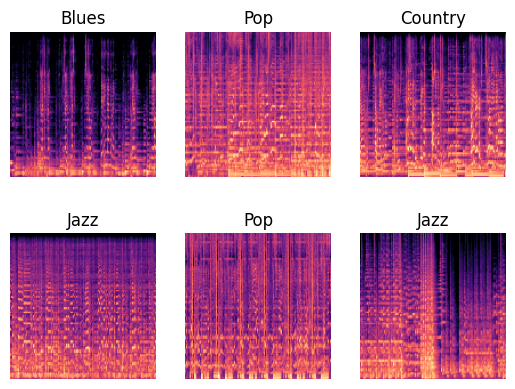

In [ ]:
visualize_samples_from_dataloader_batch(gtzan_test_dl, gtzan_classes, samples=6)

# CNN model - PyTorch

In [13]:
# 4 convolutional layers
# layer 1 and 2:
#   64 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#   
# layer 3 and 4:
#   128 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#
# dropout 0.2
#
# output:
#   fully connected linear layer

class CNN(nn.Module):
    def __init__(self, img_size, channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened feature map
        self.flattened_size = (img_size // 16) * (img_size // 16) * 128
        # max pooling reduces image width by /16 and image height by /16
        # 128 is the number of kernels in the last convolutional layer
        
        self.fc = nn.Linear(self.flattened_size, num_classes) # Logits, not probabilities
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        
        x = x.view(-1, self.flattened_size)  # Flatten the feature map
        x = self.fc(x)
        
        return x

# Metrics - multiclass and binary

Multiclass metrics

In [ ]:
# Metrics calculated and displayed:
# - EVERY TRAINING loop
# - EVERY VALIDATION loop.
# These metrics are also part of TEST loop.
def create_basic_multiclass_metrics(num_classes):
    return { "macro_accuracy": MulticlassAccuracy(device=device, average='macro', num_classes=num_classes),
             "micro_accuracy": MulticlassAccuracy(device=device, average='micro'),
             "accuracy_per_class": MulticlassAccuracy(device=device, average=None, num_classes=num_classes),
             
             "macro_f1": MulticlassF1Score(device=device, average='macro', num_classes=num_classes), 
            }
    
# Full metric set (contains basic set) calculated and displayed on:
# - LAST VALIDATION loop
# - TEST loop
# This is done to reduce clutter in the output and to calculate the full metric set
# only when the results are most useful.
def create_full_multiclass_metrics(num_classes):
    basic_metrics = create_basic_multiclass_metrics(num_classes)
    return { **basic_metrics,
            
             "micro_f1": MulticlassF1Score(device=device, average='micro'),
             "f1_per_class": MulticlassF1Score(device=device, average=None, num_classes=num_classes),
            
             "macro_precision": MulticlassPrecision(device=device, average='macro', num_classes=num_classes),
             "micro_precision": MulticlassPrecision(device=device, average='micro'),
             "precision_per_class": MulticlassPrecision(device=device, average=None, num_classes=num_classes),
             
             "macro_recall": MulticlassRecall(device=device, average='macro', num_classes=num_classes),
             "micro_recall": MulticlassRecall(device=device, average='micro'),
             "recall_per_class": MulticlassRecall(device=device, average=None, num_classes=num_classes), 
             
             "confusion_matrix": MulticlassConfusionMatrix(device=device, num_classes=num_classes),
           }

Note:

issue https://github.com/pytorch/torcheval/pull/199 for TorchEval mentions that the warning message for MulticlassPrecision(average=None) is misleading.

The warning says that both the ground truth AND predictions have n=0 for some classes, but in fact it takes only ground truth OR predictions to have n=0 for this warning to appear. So, if a model just never predicts a particular class in an epoch, this warning appears despite it not being an architectural mistake.

Binary metrics

In [ ]:
# TODO

Tool methods to display metrics and to reset/update/compute them

In [56]:
def draw_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(7, 7))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, linewidths=0, linecolor='black')

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [54]:
def reset_metrics(metrics):
    [metric.reset() for metric in metrics.values()]

# numerical labels: 0, 1, 2, 3, ...
def update_metrics(metrics, logits, numerical_labels):
    [metric.update(logits, numerical_labels) for metric in metrics.values()]

def compute_metrics(metrics):
    return {name: metric.compute() for name, metric in metrics.items()}

def print_metrics(metrics, class_names): 
    for name, metric in metrics.items():
        value = metric.tolist()
        
        if (name == 'confusion_matrix'):
            draw_confusion_matrix(value, class_names)
        elif isinstance(value, list):  # one number result for each class
            [print(f"{class_names[i]}: {value[i]:.4f}", end=" ") for i in range(len(value))]
            print()
        else:                          # one number result for all classes
            print(f"{name}: {value:.4f}")    

# Training/Test loops - PyTorch

In [17]:
#==================================================================================  
# Test loop
#==================================================================================  
def test_loop(model, metrics, class_names, test_dl):
    reset_metrics(metrics)
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not calculate gradients
        for inputs, labels in test_dl: # get batch (batch_size specified during DataLoader creation)
            outputs = model(inputs)                       # forward pass
            update_metrics(metrics, outputs, labels)      # update metrics after batch
    
    results_copy = compute_metrics(metrics) # calculate metrics after whole epoch
    print_metrics(results_copy, class_names)
    reset_metrics(metrics)
    return results_copy

In [62]:
# Training and optional validation at end of epoch
def training_loop(model, epochs, basic_metrics, class_names, train_dl, val_dl = None, full_metrics = None):
    is_binary_classification = len(class_names) == 2
    
    # PREDICTIONS: logits, LABELS: numerical
    loss_function = nn.BCEWithLogitsLoss if is_binary_classification else nn.CrossEntropyLoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    reset_metrics(basic_metrics)
    
    #==================================================================================  
    # Training loop
    #==================================================================================  
    for epoch in range(epochs):
        model.train() # training mode
        running_loss = 0.0
        for inputs, labels in train_dl: # get batch (batch_size specified during DataLoader creation)
            optimizer.zero_grad()           # zero the parameter gradients
            outputs = model(inputs)         # forward pass
                     
            loss = loss_function(outputs, labels) # calculate loss (logits, numerical labels)
            update_metrics(basic_metrics, outputs, labels)
            
            loss.backward()                 # backward pass
            optimizer.step()                # optimize weights
            running_loss += loss.item()     # accumulate loss
            
        # Calculate, display and reset TRAINING loop metrics
        print("TRAINING=======") 
        print(f"[EPOCH {epoch+1}], LOSS: {running_loss/len(train_dl)}")   
        computed_basic_metrics = compute_metrics(basic_metrics)
        print_metrics(computed_basic_metrics, class_names)
        reset_metrics(basic_metrics)
        
        #==================================================================================  
        # VALIDATION at end of epoch if val_dl is provided
        #================================================================================== 
        if val_dl is not None:
            print("VALIDATION=======") 
            
            # Calculate and display FULL METRIC SET if its the LAST VALIDATION loop
            # and the full metric set was provided
            if epoch == epochs - 1 and full_metrics is not None:
                test_loop(model, full_metrics, class_names, val_dl)
            else:
                test_loop(model, basic_metrics, class_names, val_dl)
        
        print("=====================================")

# Create and train GTZAN model

In [65]:
model_gtzan = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(gtzan_classes)).to(device) #! model to device

In [66]:
gtzan_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(gtzan_classes))
gtzan_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(gtzan_classes))

epochs: 25

| batch_size | val macro-accuracy | test macro-accuracy |
| ----| ------ |------|
| 32  | 64.4%  | 58%  |


TRAINING=======
[EPOCH 1], LOSS: 1.660304732322693
macro_accuracy: 0.4925
micro_accuracy: 0.4925
Blues: 0.3625 Classical: 0.7250 Country: 0.3375 Disco: 0.3000 Hip-Hop: 0.5875 Jazz: 0.5375 Metal: 0.7875 Pop: 0.5125 Reggae: 0.4875 Rock: 0.2875 
macro_f1: 0.4894
VALIDATION=======
macro_accuracy: 0.4800
micro_accuracy: 0.4796
Blues: 0.3000 Classical: 0.4000 Country: 0.9000 Disco: 0.0000 Hip-Hop: 0.7000 Jazz: 0.2222 Metal: 0.8000 Pop: 0.7000 Reggae: 0.7778 Rock: 0.0000 
macro_f1: 0.4244
TRAINING=======
[EPOCH 2], LOSS: 1.240737600326538
macro_accuracy: 0.5725
micro_accuracy: 0.5725
Blues: 0.5000 Classical: 0.7750 Country: 0.5000 Disco: 0.3500 Hip-Hop: 0.6750 Jazz: 0.5625 Metal: 0.8375 Pop: 0.7250 Reggae: 0.5125 Rock: 0.2875 
macro_f1: 0.5679
VALIDATION=======
macro_accuracy: 0.4656
micro_accuracy: 0.4592
Blues: 0.4000 Classical: 0.2000 Country: 0.5000 Disco: 0.0000 Hip-Hop: 0.3000 Jazz: 1.0000 Metal: 0.8000 Pop: 0.7000 Reggae: 0.5556 Rock: 0.2000 
macro_f1: 0.4322
TRAINING=======
[EPOCH 3],

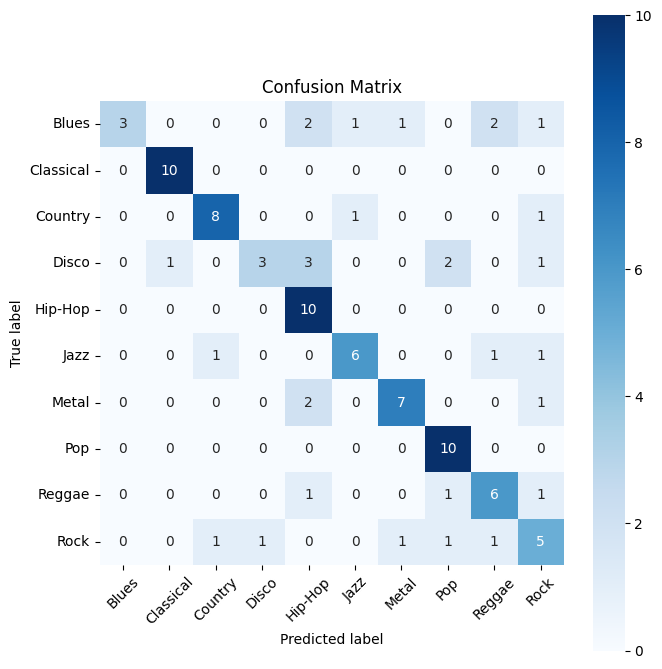

In [68]:
training_loop(model=model_gtzan,
              epochs=20,
              basic_metrics=gtzan_basic_multiclass_metrics,
              class_names=gtzan_classes,
              train_dl=gtzan_train_dl,
              val_dl=gtzan_val_dl,
              full_metrics=gtzan_full_multiclass_metrics)

macro_accuracy: 0.5400
micro_accuracy: 0.5400
Blues: 0.3000 Classical: 0.9000 Country: 0.5000 Disco: 0.1000 Hip-Hop: 0.6000 Jazz: 0.4000 Metal: 0.8000 Pop: 0.8000 Reggae: 0.5000 Rock: 0.5000 
macro_f1: 0.5378
micro_f1: 0.5400
Blues: 0.3750 Classical: 0.9474 Country: 0.5882 Disco: 0.1538 Hip-Hop: 0.3871 Jazz: 0.5333 Metal: 0.8421 Pop: 0.6667 Reggae: 0.3846 Rock: 0.5000 
macro_precision: 0.5906
micro_precision: 0.5400
Blues: 0.5000 Classical: 1.0000 Country: 0.7143 Disco: 0.3333 Hip-Hop: 0.2857 Jazz: 0.8000 Metal: 0.8889 Pop: 0.5714 Reggae: 0.3125 Rock: 0.5000 
macro_recall: 0.5400
micro_recall: 0.5400
Blues: 0.3000 Classical: 0.9000 Country: 0.5000 Disco: 0.1000 Hip-Hop: 0.6000 Jazz: 0.4000 Metal: 0.8000 Pop: 0.8000 Reggae: 0.5000 Rock: 0.5000 


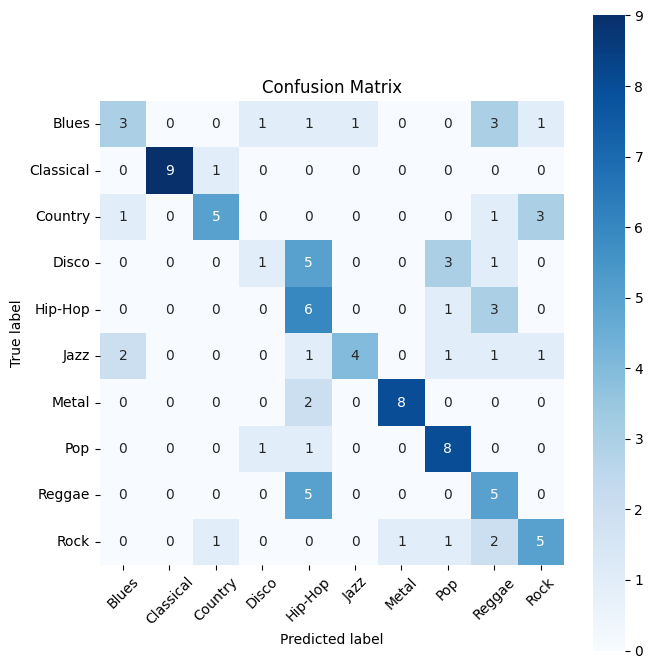

In [69]:
results = test_loop(model_gtzan, gtzan_full_multiclass_metrics, gtzan_classes, gtzan_test_dl)

Different micro and macro when a class has, for example, no TP in precision TP/(TP+FP)

Macro DOES count the 0, micro does not

Example:

(0.75+0.6+0.5714+0+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/10 = 0.53297

(0.75+0.6+0.5714+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/9 = 0.592

# Load FMA-small inputs

With val

In [14]:
BATCH_SIZE = 8
CHANNELS = 3

In [ ]:
fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_val_dl = prepare_dataloader_based_on_df(fma_small_val_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-small model

In [ ]:
model_fma_small = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(fma_small_top_classes)).to(device)

In [22]:
training_loop(model_fma_small, 8, fma_small_train_dl, fma_small_val_dl)

Epoch 1, Loss: 2.083809417039156
Validation Accuracy: 31.5%
Epoch 2, Loss: 1.6647054379433393
Validation Accuracy: 38.125%
Epoch 3, Loss: 1.5345848057791591
Validation Accuracy: 40.875%
Epoch 4, Loss: 1.4832319397851825
Validation Accuracy: 46.375%
Epoch 5, Loss: 1.4342508152127267
Validation Accuracy: 31.5%
Epoch 6, Loss: 1.400188159532845
Validation Accuracy: 46.875%
Epoch 7, Loss: 1.359112393297255
Validation Accuracy: 48.5%
Epoch 8, Loss: 1.3095306254550814
Validation Accuracy: 41.75%


In [28]:
test_loop(model_fma_small, fma_small_test_dl)

Test Accuracy: 37.875%


# Function definition for binary classification

In [28]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# Define binary metrics

In [35]:
binary_metrics=[tf.keras.metrics.BinaryAccuracy(),
                    #tf.keras.metrics.AUC(curve='ROC'),
                ]

# GTZAN binary classification

In [ ]:
#todo - actually find the 2 best classes

In [31]:
BATCH_SIZE = 8
CHANNELS = 3

In [26]:
GTZAN_CLASS_1 = 'Classical'
GTZAN_CLASS_2 = 'Metal'
gtzan_binary_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [29]:
gtzan_train_df_2 = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_binary_classes)
gtzan_val_df_2 = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_binary_classes)
gtzan_test_df_2 = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_binary_classes)

In [ ]:
gtzan_train_ds_2 = prepare_dataloader_based_on_df(gtzan_train_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_val_ds_2 = prepare_dataloader_based_on_df(gtzan_val_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_test_ds_2 = prepare_dataloader_based_on_df(gtzan_test_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00000.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00001.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00002.png' b'Classical'
Data set size: 160
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00011.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00022.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00027.png' b'Classical'
Data set size: 18
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00004.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00006.png' b'Classical'
b'C:\\VisualStudi

In [33]:
model_gtzan_2 = create_CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=2)

In [36]:
model_gtzan_2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=binary_metrics)

In [38]:
model_gtzan_2.fit(
  gtzan_train_ds_2,
  validation_data=gtzan_val_ds_2,
  epochs=2
)

Epoch 1/2


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [ ]:
model_gtzan_2.evaluate(
  gtzan_test_ds_2
)